# Final Project: Yoga pose Image Classification with VGG16
## Model finetuning in AWS SageMaker: script mode, hyperparameter tuning, model profiling and debugger, custom dataset, and others good ML engineering practices

VGG16 image classification model is finetuned with a costum dataset of yoga pose images containing 107 classes each one corresponding to a yoga pose. The model is submited and deployed in AWS Sagemaker.

The Sagemaker ML framework used is PyTorch {`sagemaker.pytorch`}. The model definition and the training and inference code are passed in to PyTorch container via Sagemaker script mode. Script mode allows the use of custom training and inference code together with common ML framework containers mantained by AWS.

This notebook represents the *submission script* and contains code to download and preprocess the data as well as Sagemaker APIs setups to train and deploy the model.

The *training scrip* used is `hpo.py`. It contains the model definition and the code to train and validate the model and save it to S3 (`torch.save(model.state_dict(), "model_dir/model.pth")`).

The *inference script* (`inference.py`) contains the code to the Sagemaker Model Server functions for deserializing the trained model and load it for inference (`model.load_state_dict(torch.load(model_dir))`) and for translating an endpoint request to an inference call to the model.


## <a name="0">Notebook content:</a>
1. <a href="#1">Notebook setup</a>
2. <a href="#2">Dataset</a><br>
    2.1. <a href="#2.1">AWS S3 configuration</a><br>
    2.2. <a href="#2.2">Dataset: download, extract, and split</a><br>
    2.3. <a href="#2.3">Manifest files</a><br>
    2.4 <a href="#2.4">Define Data Channels</a>
3. <a href="#3">Train and Deploy the model</a><br>
    5.1. <a href="#5.1">Create Model</a><br>
    5.2. <a href="#5.2">Create Endpoint</a><br>
    5.3. <a href="#5.3">Perform Inference</a><br>
    5.4. <a href="#5.4">Clean up</a>


## 1. <a name="1">Notebook setup</a>
(<a href="#0">Go to top</a>)

In [1]:
# Import any packages that might be needed
# For instance Boto3 and Sagemaker and PyTorch ML framework 
import boto3
import sagemaker

from sagemaker import get_execution_role

from sagemaker.pytorch import PyTorch

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import requests
import shutil

import io
import pickle

In [ ]:
#boto3.Session().get_available_services()

## 2. <a name="2">Dataset</a>
(<a href="#0">Go to top</a>)

The dataset used is composed of a total of 5994 images of yoga poses. It contains 107 classes of images, each one corresponding to a yoga poses, such as 'adho mukha svanasana', chakravakasana, savasana, etc. For the scope of this project the datset is splitted in 3 subsets as following: 3553 images in the training dataset, 1284 images in the test dataset and 1157 images in the validation dataset.

The dataset used here is a modification of kaggle [yoga-pose-image-classification-dataset](https://www.kaggle.com/datasets/shrutisaxena/yoga-pose-image-classification-dataset?select=dataset) dataset and can be downloaded from [rgb-only-yoga-pose-dataset](https://www.kaggle.com/datasets/franciscadossantos/rgb-only-yoga-pose-dataset).


**Support material:**

1. kaggle. [Yoga Pose Image classification dataset](https://www.kaggle.com/datasets/shrutisaxena/yoga-pose-image-classification-dataset?select=dataset)
2. kaggle. [RGB-only Yoga Pose Dataset](https://www.kaggle.com/datasets/franciscadossantos/rgb-only-yoga-pose-dataset)
3. GitHub. [Kaggle API](https://github.com/Kaggle/kaggle-api)
4. stackoverflow. [Download Kaggle Dataset by using Python](https://stackoverflow.com/questions/49386920/download-kaggle-dataset-by-using-python)
5. GitHub. [split-folders](https://github.com/jfilter/split-folders)


### 2.1. <a name="2.1">AWS S3 configuration</a>
(<a href="#0">Go to top</a>)

In [2]:
# grab sagemaker session and define s3 bucket name or use sagemaker.Session().default_bucket
# then, define file path prefix to send data to S3 bucket

sm_session = sagemaker.Session()
bucket = "capstone-project-sett22" ##"capstone-project-udc2022"  ##sm_session.default_bucket()

prefix = "yoga-data"

print(f"Bucket: {bucket}")
print(f"S3 path: {bucket}/{prefix}")

input_data = f"s3://{bucket}/{prefix}"

Bucket: capstone-project-sett22
S3 path: capstone-project-sett22/yoga-data


### 2.2. <a name="2.2">Dataset: download, extract, and split</a>
(<a href="#0">Go to top</a>)

#### 2.2.1. <a name="2.2.1">Download data from kaggle</a>

**Note:** first of all download `kaggle.json` from kaggle website and upload it to local directory

In [7]:
# pip install kaggle CLI
!pip install -q kaggle

In [9]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

kaggle.json


In [10]:
!chmod 600 ~/.kaggle/kaggle.json  # ensure that other users do not have read access to your credentials

In [12]:
%%time

# download the dataset of interest (using kaggle CLI)

# original dataset
##!kaggle datasets download -d shrutisaxena/yoga-pose-image-classification-dataset

# transformed dataset (only images in rgb mode)
!kaggle datasets download -d franciscadossantos/rgb-only-yoga-pose-dataset

 75%|██████████████████████████████▏         | 78.0M/103M [00:00<00:00, 190MB/s]
100%|█████████████████████████████████████████| 103M/103M [00:00<00:00, 200MB/s]
CPU times: user 28.9 ms, sys: 4.83 ms, total: 33.7 ms
Wall time: 1.34 s


In [14]:
%%time

# extract / unzip data with {shutil}
#shutil.unpack_archive('./yoga-pose-image-classification-dataset.zip', './yoga_data')
shutil.unpack_archive('./rgb-only-yoga-pose-dataset.zip', './yoga_data')

"""
# OR
# unzip data using aws CLI
!unzip -d yoga_data yoga-pose-image-classification-dataset.zip
"""

CPU times: user 956 ms, sys: 159 ms, total: 1.12 s
Wall time: 1.28 s


'\n# OR\n# unzip data using aws CLI\n!unzip -d yoga_data yoga-pose-image-classification-dataset.zip\n'

#### 2.2.2. <a name="2.2.2">Explore data: List the classes (yoga poses) and count the number of images</a>

In [3]:
# create a dictionary/list of classes (107 classes) that can be used later when selecting image for quering the model

# get the list of all directories within /content/yoga_data/dataset
path = "./yoga_data/dataset"
cls_list = os.listdir(path)
cls_list.sort()

cls_dict = {}
for i, term in enumerate(cls_list, 1):
    cls_dict[i] = term

print(f"Number of Classes: {len(cls_list)}")

Number of Classes: 107


In [4]:
cls_dict

{1: 'adho mukha svanasana',
 2: 'adho mukha vriksasana',
 3: 'agnistambhasana',
 4: 'ananda balasana',
 5: 'anantasana',
 6: 'anjaneyasana',
 7: 'ardha bhekasana',
 8: 'ardha chandrasana',
 9: 'ardha matsyendrasana',
 10: 'ardha pincha mayurasana',
 11: 'ardha uttanasana',
 12: 'ashtanga namaskara',
 13: 'astavakrasana',
 14: 'baddha konasana',
 15: 'bakasana',
 16: 'balasana',
 17: 'bhairavasana',
 18: 'bharadvajasana i',
 19: 'bhekasana',
 20: 'bhujangasana',
 21: 'bhujapidasana',
 22: 'bitilasana',
 23: 'camatkarasana',
 24: 'chakravakasana',
 25: 'chaturanga dandasana',
 26: 'dandasana',
 27: 'dhanurasana',
 28: 'durvasasana',
 29: 'dwi pada viparita dandasana',
 30: 'eka pada koundinyanasana i',
 31: 'eka pada koundinyanasana ii',
 32: 'eka pada rajakapotasana',
 33: 'eka pada rajakapotasana ii',
 34: 'ganda bherundasana',
 35: 'garbha pindasana',
 36: 'garudasana',
 37: 'gomukhasana',
 38: 'halasana',
 39: 'hanumanasana',
 40: 'janu sirsasana',
 41: 'kapotasana',
 42: 'krounchasa

In [4]:
#counting the number of images

dir = path
sum = 0

for i, cls in enumerate(cls_list, 1):
    path = os.path.join(dir, cls)
    for (r, d, f) in os.walk(path):
        sum += len(f)
print("Total number of images in the data set: ", sum)

Total number of images in the data set:  5994


#### 2.2.3. <a name="2.2.3">Split data into train, validation and test sets</a>

In [23]:
!pip install split-folders

In [ ]:
# -----------------------------------------------------------------------------------------

In [37]:
## RUN THIS CELL ONLY IF NEEDED (e.g, if you need to run again the code of the next cell bellow)

# delete local copy of datasets (train, validation, and test)
if os.path.exists("./yoga_data/subsets"):
    shutil.rmtree("./yoga_data/subsets") #remove non-empty directory {shutil}
    #os.rmdir('./yoga_data/subsets') #remove empty directory {os}
else:
    print("No files found in the directory")


In [ ]:
# -----------------------------------------------------------------------------------------

In [24]:
#randomly sample data into train, validation and test sets/directories (0.7, 0.1, 0.2)

import splitfolders

input_folder = root

splitfolders.ratio(input_folder, output="./yoga_data/subsets", seed=1337, ratio=(.7, .1, .2), group_prefix=None, move=False)


Copying files: 5994 files [00:00, 7445.87 files/s]


In [25]:
#!ls ./yoga_data/subsets
os.listdir("./yoga_data/subsets")

['val', 'test', 'train']

In [26]:
## count number of images in each dataset

root = "./yoga_data/subsets"

dset_dict = {
    'train' : 0,
    'val' : 0,
    'test' : 0
}
for k in dset_dict.keys():
    path = os.path.join(root, k)
    for (r, d, f) in os.walk(path, topdown=True):
        for file in f:
            dset_dict[k] += 1 

print(dset_dict)

{'train': 4150, 'val': 550, 'test': 1294}


#### 2.2.4. <a name="2.2.4">Upload data to AWS S3</a>

In [9]:
%%time

# upload all the data to S3
## upload local 'data' directories (train, test, and val) to S3

# upload data to S3 using aws CLI: aws s3 cp <source> <target> [--options]
!aws s3 cp ./yoga_data/subsets/train s3://{bucket}/{prefix}/train --recursive
!aws s3 cp ./yoga_data/subsets/test s3://{bucket}/{prefix}/test --recursive
!aws s3 cp ./yoga_data/subsets/val s3://{bucket}/{prefix}/val --recursive

"""
## OR upload using sagemaker session
input_data = sm_session.upload_data(path='./yoga_data/subsets', bucket=bucket, key_prefix=prefix)
"""

## print S3 URI
print('path to data in S3: {}'.format(input_data))


upload: yoga_data/subsets/train/adho mukha svanasana/10. screen-shot-2017-09-15-at-17.00.06-1024x585.jpg to s3://capstone-project-udc2022/yoga-data/train/adho mukha svanasana/10. screen-shot-2017-09-15-at-17.00.06-1024x585.jpg
upload: yoga_data/subsets/train/adho mukha svanasana/1. 1.jpg to s3://capstone-project-udc2022/yoga-data/train/adho mukha svanasana/1. 1.jpg
upload: yoga_data/subsets/train/adho mukha svanasana/1. 5-benefits-of-downward-facing-dog-pose.jpg to s3://capstone-project-udc2022/yoga-data/train/adho mukha svanasana/1. 5-benefits-of-downward-facing-dog-pose.jpg
upload: yoga_data/subsets/train/adho mukha svanasana/17. screen_shot_2014-03-20_at_2.05.15_pm.jpg to s3://capstone-project-udc2022/yoga-data/train/adho mukha svanasana/17. screen_shot_2014-03-20_at_2.05.15_pm.jpg
upload: yoga_data/subsets/train/adho mukha svanasana/11. yoga_anatomy_using_muscle_awareness_to_lower_your_heels_in_downward_facing_dog_pose.jpg to s3://capstone-project-udc2022/yoga-data/train/adho mukha

In [ ]:
# -----------------------------------------------------------------------------------------

In [60]:
# OPTIONAL: delete local copy of .zip data file
if os.path.exists('./yoga-pose-image-classification-dataset.zip'):
    os.remove('./yoga-pose-image-classification-dataset.zip') #remove files
else:
    print("Files does not exist")

"""
# OPTIONAL: delete extra local copy of data 
if os.path.exists("./yoga_data/dataset"):
    shutil.rmtree("./yoga_data/dataset") #remove non-empty directory {shutil}
    #os.rmdir('./yoga_data/dataset') #remove empty directory {os}
else:
    print("No files found in the directory")
"""

'\n# OPTIONAL: delete extra local copy of data \nif os.path.exists("./yoga_data/dataset"):\n    shutil.rmtree("./yoga_data/dataset") #remove non-empty directory {shutil}\n    #os.rmdir(\'./yoga_data/dataset\') #remove empty directory {os}\nelse:\n    print("No files found in the directory")\n'

In [ ]:
# -----------------------------------------------------------------------------------------

### 2.3. <a name="2.3">Manifest files</a>
(<a href="#0">Go to top</a>)

["A .lst file is a tab-separated file with three columns that contains a list of image files. The first column specifies the image index, the second column specifies the class label index for the image, and the third column specifies the relative path of the image file. The image index in the first column must be unique across all of the images. The set of class label indices are numbered successively and the numbering should start with 0. For example, 0 for the cat class, 1 for the dog class, and so on for additional classes."](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) (Sagemaker Developer Guide: Image Classification Algorithm. Train with Image Format)

In [10]:
# Build a list file (.lst file) with the labels for each set of data
# "labels" are classes numbers from from 0 to 106 (107 classes)
## Note, labels start from zero (0) to meet Sagemaker requirements
# "s3_path" are dir/file_name
# "row" are the row indexes [0, num_images-1]

def create_manifest_file(dir, prefix):
    path = os.path.join(dir, prefix)
    dir_list = os.listdir(path)
    dir_list.sort()

    filepath_list = []
    label_list = []
    for i, label in enumerate(dir_list, 0):
        directory = os.path.join(path, label)
        for (r, d, f) in os.walk(directory, topdown=True):
            for file in f:
                filepath_list.append(os.path.join(label, file))
                label_list.append(i) ## [0 to 106]

    pd.DataFrame({
        "row":range(len(filepath_list)),
        "labels":label_list,
        "s3_path":filepath_list
    }).to_csv(path_or_buf=os.path.join(dir, f"{prefix}.lst"), sep='\t', header=False, index=False)
    
    print(f"{prefix}.lst created!")

In [11]:
dir = "./yoga_data/subsets"

create_manifest_file(dir, 'train')
create_manifest_file(dir, 'test')
create_manifest_file(dir, 'val')

train.lst created!
test.lst created!
val.lst created!


In [12]:
!ls ./yoga_data/subsets

test  test.lst	train  train.lst  val  val.lst


In [13]:
%%time
# upload list files to s3

train_lst_path = sm_session.upload_data(path='./yoga_data/subsets/train.lst', bucket=bucket, key_prefix=prefix)
print('train.lst uploaded to the s3 path:\n {}'.format(train_lst_path))

test_lst_path = sm_session.upload_data(path='./yoga_data/subsets/test.lst', bucket=bucket, key_prefix=prefix)
print('test.lst uploaded to the s3 path:\n {}'.format(test_lst_path))

valid_lst_path = sm_session.upload_data(path='./yoga_data/subsets/val.lst', bucket=bucket, key_prefix=prefix)
print('valid.lst uploaded to the s3 path:\n {}'.format(valid_lst_path))

train.lst uploaded to the s3 path:
 s3://capstone-project-udc2022/yoga-data/train.lst
test.lst uploaded to the s3 path:
 s3://capstone-project-udc2022/yoga-data/test.lst
valid.lst uploaded to the s3 path:
 s3://capstone-project-udc2022/yoga-data/val.lst
CPU times: user 72.3 ms, sys: 9.13 ms, total: 81.4 ms
Wall time: 510 ms


In [ ]:
# -----------------------------------------------------------------------------------------

In [5]:
## RUN THIS CELL ONLY IF NEEDED
## e.g., if you need to re-define the paths to metadata (s3 paths to .lst files)

input_data = f"s3://{bucket}/{prefix}"

train_lst_path = f"s3://{bucket}/{prefix}/train.lst"

test_lst_path = f"s3://{bucket}/{prefix}/test.lst"

valid_lst_path = f"s3://{bucket}/{prefix}/val.lst"


In [ ]:
# -----------------------------------------------------------------------------------------

In [6]:
print('Bucket:\n {}'.format(bucket))

print('s3 path to data:\n {}'.format(input_data))

print('s3 path to train.lst:\n {}'.format(train_lst_path))

print('s3 path to test.lst:\n {}'.format(test_lst_path))

print('s3 path to valid.lst:\n {}'.format(valid_lst_path))

Bucket:
 capstone-project-sett22
s3 path to data:
 s3://capstone-project-sett22/yoga-data
s3 path to train.lst:
 s3://capstone-project-sett22/yoga-data/train.lst
s3 path to test.lst:
 s3://capstone-project-sett22/yoga-data/test.lst
s3 path to valid.lst:
 s3://capstone-project-sett22/yoga-data/val.lst


In [ ]:
# -----------------------------------------------------------------------------------------

### 2.4 <a name="2.4">Define Data Channels</a>
(<a href="#0">Go to top</a>)


In [7]:
# model data channels

model_inputs = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data="s3://capstone-project-sett22/yoga-data/train/",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "test": sagemaker.inputs.TrainingInput(
        s3_data="s3://capstone-project-sett22/yoga-data/test/",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "valid": sagemaker.inputs.TrainingInput(
        s3_data="s3://capstone-project-sett22/yoga-data/val/",
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "train_lst": sagemaker.inputs.TrainingInput(
        s3_data=train_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "test_lst": sagemaker.inputs.TrainingInput(
        s3_data=test_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    ),
    "valid_lst": sagemaker.inputs.TrainingInput(
        s3_data=valid_lst_path,
        distribution='FullyReplicated',
        content_type='application/x-image',
        s3_data_type='S3Prefix',
    )
}


## 3. <a name="3">Train and Deploy the model</a>
(<a href="#0">Go to top</a>)

**Support material:**

1. Sagemaker Developer Guide: [Request Inferences from a Deployed Service](https://docs.aws.amazon.com/sagemaker/latest/dg/neo-requests-sdk.html)
2. Sagemaker Read the Docs: [End-to-End Multiclass Image Classification Example](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-fulltraining.html#Create-endpoint-configuration)
3. Use PyTorch with the SageMaker Python SDK. Deploy PyTorch Models. [The SageMaker PyTorch Model Server](https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#id3)
4. AWS Blog: [Bring your own model with Amazon SageMaker script mode](https://aws.amazon.com/blogs/machine-learning/bring-your-own-model-with-amazon-sagemaker-script-mode/)
5. Sagemaker Developer Guide: [Deploy a Compiled Model Using SageMaker SDK](https://docs.aws.amazon.com/sagemaker/latest/dg/neo-deployment-hosting-services-sdk.html)
6. Sagemaker Read the Docs: [Predictors](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html#sagemaker.predictor.Predictor)

### 5.1. <a name="5.1">Create Model</a>
(<a href="#0">Go to top</a>)

In [9]:
# define hyperparameters values

epochs = '30'
test_batch_size = '20'
batch_size = '30'
lr = '0.12182095106235333'

In [ ]:
%%time

hyperparameters = {
    'epochs': epochs,
    'batch_size': batch_size,
    'test_batch_size': test_batch_size,
    'lr': lr
}

model = PyTorch(
    entry_point="hpo.py",
    base_job_name="yoga-data-model", #prefix for training job name
    hyperparameters=hyperparameters,
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.4xlarge",
    framework_version="1.8.0",
    py_version="py36",
    disable_profiler = True
)

model.fit(inputs=model_inputs, logs='All')

2022-10-12 15:31:42 Starting - Starting the training job...
2022-10-12 15:31:57 Starting - Preparing the instances for training......
2022-10-12 15:33:12 Downloading - Downloading input data.....Train Epoch: 2#011|#011Average Loss: 0.173463266671422
Train Epoch: 5#011|#011Average Loss: 0.13131169979830823
Train Epoch: 6#011|#011Average Loss: 0.12272152314703148
Train Epoch: 8#011|#011Average Loss: 0.10957535536892443
Train Epoch: 9#011|#011Average Loss: 0.10498136339417423
Train Epoch: 12#011|#011Average Loss: 0.09421086848500264
Train Epoch: 13#011|#011Average Loss: 0.09093406865395695
Train Epoch: 16#011|#011Average Loss: 0.08392739754125296
Train Epoch: 17#011|#011Average Loss: 0.08199982080114893
Train Epoch: 20#011|#011Average Loss: 0.07790635182196835
Train Epoch: 21#011|#011Average Loss: 0.07653101618031422
Train Epoch: 22#011|#011Average Loss: 0.0758466995480549
Train Epoch: 25#011|#011Average Loss: 0.07203090590166758
Train Epoch: 26#011|#011Average Loss: 0.07096223394554782
T

In [11]:
print(f"Training job name: {model.latest_training_job.name}")

Training job name: yoga-data-model-2022-10-12-15-31-41-280


In [12]:
model_data_url = model.model_data
print(f"Model data location in s3: {model_data_url}")

Model data location in s3: s3://sagemaker-us-east-1-967161726274/yoga-data-model-2022-10-12-15-31-41-280/output/model.tar.gz


In [ ]:
# -----------------------------------------------------------------------------------------

In [ ]:
## re-define latest_training_job and model_data_url variables, if needed

In [6]:
latest_training_job = "yoga-data-model-2022-10-12-15-31-41-280"

In [7]:
model_data_url = "s3://sagemaker-us-east-1-967161726274/yoga-data-model-2022-10-12-15-31-41-280/output/model.tar.gz"

In [ ]:
# -----------------------------------------------------------------------------------------

#### 5.1.1 <a name="5.1.1">RUN MODEL FOR 55 EPOCHS</a>

In [8]:
# define hyperparameters values

epochs = '55'
test_batch_size = '20'
batch_size = '30'
lr = '0.12182095106235333'

In [ ]:
%%time

hyperparameters = {
    'epochs': epochs,
    'batch_size': batch_size,
    'test_batch_size': test_batch_size,
    'lr': lr
}

model = PyTorch(
    entry_point="hpo.py",
    base_job_name="yoga-data-model", #prefix for training job name
    hyperparameters=hyperparameters,
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.p2.xlarge", #"ml.m5.4xlarge",
    framework_version="1.8.0",
    py_version="py36",
    disable_profiler = True
)

model.fit(inputs=model_inputs, logs='All')

2022-11-16 08:08:19 Starting - Starting the training job...
2022-11-16 08:08:45 Starting - Preparing the instances for training............
2022-11-16 08:10:26 Downloading - Downloading input data....Train Epoch: 2#011|#011Average Loss: 0.1731313002253153
Train Epoch: 3#011|#011Average Loss: 0.15597476281315448
Train Epoch: 4#011|#011Average Loss: 0.14172544037003115
Train Epoch: 5#011|#011Average Loss: 0.13086833936622344
Train Epoch: 6#011|#011Average Loss: 0.12238155568938658
Train Epoch: 7#011|#011Average Loss: 0.11501992389380214
Train Epoch: 8#011|#011Average Loss: 0.1092265741221876
Train Epoch: 9#011|#011Average Loss: 0.10395501062094448
Train Epoch: 10#011|#011Average Loss: 0.10035106544035027
Train Epoch: 11#011|#011Average Loss: 0.09736009212861578
Train Epoch: 12#011|#011Average Loss: 0.0930097802288561
Train Epoch: 13#011|#011Average Loss: 0.09126490893134151
Train Epoch: 14#011|#011Average Loss: 0.0884219428717372
Train Epoch: 22#011|#011Average Loss: 0.07539935913430638


In [11]:
print(f"Training job name: {model.latest_training_job.name}")

Training job name: yoga-data-model-2022-11-16-08-08-18-795


In [12]:
model_data_url = model.model_data
print(f"Model data location in s3: {model_data_url}")

Model data location in s3: s3://sagemaker-us-east-1-967161726274/yoga-data-model-2022-11-16-08-08-18-795/output/model.tar.gz


In [ ]:
# -----------------------------------------------------------------------------------------

In [ ]:
## re-define latest_training_job and model_data_url variables, if needed

In [4]:
latest_training_job = "yoga-data-model-2022-11-16-08-08-18-795"

In [5]:
model_data_url = "s3://sagemaker-us-east-1-967161726274/yoga-data-model-2022-11-16-08-08-18-795/output/model.tar.gz"

In [ ]:
# -----------------------------------------------------------------------------------------

In [13]:
# call the sagemaker.pytorch.model.PyTorchModel constructor to create a model object

from sagemaker.pytorch.model import PyTorchModel

my_model = PyTorchModel(
    model_data = model_data_url,
    role = get_execution_role(),
    entry_point = 'inference.py',
    framework_version="1.8.0",
    py_version = 'py36'
)


### 5.2. <a name="5.2">Create Endpoint</a>
(<a href="#0">Go to top</a>)

In [14]:
%%time
# deploy model to an endpoint

from sagemaker.serializers import IdentitySerializer

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
#json_deserializer = sagemaker.deserializers.JSONDeserializer()

predictor = my_model.deploy(
    initial_instance_count = 1,
    instance_type = "ml.m5.xlarge", #"ml.m5.2xlarge" #
    serializer = jpeg_serializer,
    #deserializer = json_deserializer
)

-------!CPU times: user 34.5 s, sys: 3.71 s, total: 38.2 s
Wall time: 4min 10s


In [15]:
# grab endpoint name
print(f"Endpoint name: {predictor.endpoint_name}")

Endpoint name: pytorch-inference-2022-11-16-09-51-07-598


In [16]:
# print the status of the endpoint
client = boto3.client('sagemaker')
endpoint_response = client.describe_endpoint(EndpointName=predictor.endpoint_name)
status = endpoint_response["EndpointStatus"]
print("Endpoint creation ended with EndpointStatus = {}".format(status))

if status != "InService":
    raise Exception("Endpoint creation failed.")

Endpoint creation ended with EndpointStatus = InService


### 5.3. <a name="5.3">Perform Inference</a>
(<a href="#0">Go to top</a>)

#### 5.3.1. <a name="5.3.1">Grab validation data</a>

In [9]:
# create a list of classes sorted by indexes
image_categories = []
for i in sorted(cls_dict.keys()):
    image_categories.append(cls_dict[i])

In [18]:
image_categories

['adho mukha svanasana',
 'adho mukha vriksasana',
 'agnistambhasana',
 'ananda balasana',
 'anantasana',
 'anjaneyasana',
 'ardha bhekasana',
 'ardha chandrasana',
 'ardha matsyendrasana',
 'ardha pincha mayurasana',
 'ardha uttanasana',
 'ashtanga namaskara',
 'astavakrasana',
 'baddha konasana',
 'bakasana',
 'balasana',
 'bhairavasana',
 'bharadvajasana i',
 'bhekasana',
 'bhujangasana',
 'bhujapidasana',
 'bitilasana',
 'camatkarasana',
 'chakravakasana',
 'chaturanga dandasana',
 'dandasana',
 'dhanurasana',
 'durvasasana',
 'dwi pada viparita dandasana',
 'eka pada koundinyanasana i',
 'eka pada koundinyanasana ii',
 'eka pada rajakapotasana',
 'eka pada rajakapotasana ii',
 'ganda bherundasana',
 'garbha pindasana',
 'garudasana',
 'gomukhasana',
 'halasana',
 'hanumanasana',
 'janu sirsasana',
 'kapotasana',
 'krounchasana',
 'kurmasana',
 'lolasana',
 'makara adho mukha svanasana',
 'makarasana',
 'malasana',
 'marichyasana i',
 'marichyasana iii',
 'marjaryasana',
 'matsyasa

In [25]:
# random select from the dictionary of classes created at the begining of the notebook
image_class = random.choice(cls_list)
print(f"Class: {image_class}")

class_path = f"./yoga_data/subsets/val/{image_class}"
print(f"Path to files in this class: {class_path}")

# select random image from selected class
image = random.choice(os.listdir(class_path))
print(f"Selected image: {image}")

local_image_path = f"{class_path}/{image}"
print(f"Local path to selected image: {local_image_path}")


Class: salabhasana
Path to files in this class: ./yoga_data/subsets/val/salabhasana
Selected image: 34-0.jpg
Local path to selected image: ./yoga_data/subsets/val/salabhasana/34-0.jpg


In [49]:
type(local_image_path)

str

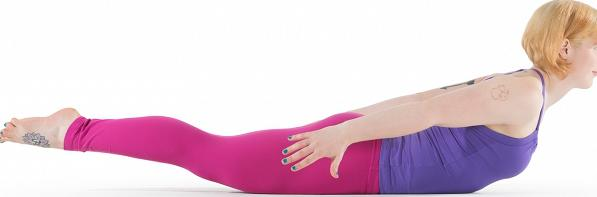

In [26]:
## Image.open() takes a file path as argument and returns a PIL.Image object
img = Image.open(local_image_path)
img.show()

In [27]:
img.close()

In [28]:
with open(local_image_path, 'rb') as f:
    payload = f.read()
    
type(payload)

bytes

#### 5.3.2. <a name="5.3.2">Test endpoint</a>

##### 5.3.2.1. <a name="5.3.2.2">Invoke Endpoint with boto3 and SageMaker runtime (Serveless inference)</a>

In [6]:
# run a prediction on the endpoint using Boto3
runtime = boto3.Session().client(service_name="runtime.sagemaker")

In [7]:
Endpoint_name = "pytorch-inference-2022-11-16-09-51-07-598"

In [29]:
inference_response = runtime.invoke_endpoint(
    EndpointName = Endpoint_name, #predictor.endpoint_name,
    ContentType="image/jpeg", #application/x-image",
    Body=payload
)

In [30]:
inference_response

{'ResponseMetadata': {'RequestId': 'f5dfc876-e57a-4cb1-9f50-10de8b75b806',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'f5dfc876-e57a-4cb1-9f50-10de8b75b806',
   'x-amzn-invoked-production-variant': 'AllTraffic',
   'date': 'Wed, 12 Oct 2022 18:26:34 GMT',
   'content-type': 'application/json',
   'content-length': '2144'},
  'RetryAttempts': 0},
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'Body': <botocore.response.StreamingBody at 0x7f1a2613e070>}

In [30]:
# result will be in json format
#result = inference_response["Body"].read()
result = inference_response['Body'].read().decode('utf-8')

# convert result to ndarray
result = json.loads(result)

result

[[-10.4629545211792,
  -7.829684734344482,
  -8.974398612976074,
  -8.521990776062012,
  -8.071063041687012,
  -7.652987957000732,
  -6.41994047164917,
  -8.28393840789795,
  -9.55566692352295,
  -10.561053276062012,
  -8.141863822937012,
  -7.406100749969482,
  -6.373645305633545,
  -7.830737590789795,
  -7.292529582977295,
  -7.075610637664795,
  -7.094058513641357,
  -8.998141288757324,
  -7.42518949508667,
  -2.097705364227295,
  -7.849673748016357,
  -7.448855876922607,
  -7.128650188446045,
  -7.042209148406982,
  -2.334521770477295,
  -4.693515300750732,
  -5.825000286102295,
  -7.913135051727295,
  -6.61928129196167,
  -4.404345989227295,
  -5.27595853805542,
  -7.817813396453857,
  -6.956653118133545,
  -6.335193157196045,
  -10.5849027633667,
  -8.190539360046387,
  -7.096057415008545,
  -5.27858304977417,
  -6.92323637008667,
  -4.558780193328857,
  -6.745044231414795,
  -9.38196086883545,
  -6.227542400360107,
  -7.008883953094482,
  -4.778720378875732,
  -2.41383695602417,

In [31]:
inference = np.argmax(result)
inference

68

#### 5.3.3. <a name="5.3.3">PRINT PREDICTION(S)</a>

In [32]:
# the result will output the probabilities for all classes
# find the class with maximum probability
index = np.argmax(result)

# print the most probable class and its probability
print(f"Result: predicted label(s) - {image_categories[index]}")

Result: predicted label(s) - salabhasana


In [33]:
cls_dict[index+1]

'salabhasana'

In [34]:
## Grab image label

print(local_image_path)
groundtruth = local_image_path.split('val/')[1].split('/')[0]
print(groundtruth)

./yoga_data/subsets/val/salabhasana/34-0.jpg
salabhasana


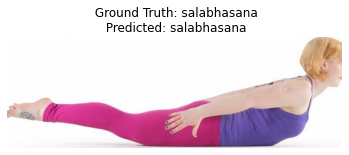

In [35]:
## plot image with the groud truth and the predicted label

from matplotlib import pyplot as plt

plt.imshow(plt.imread(local_image_path))
plt.axis('off')
plt.title(f" Ground Truth: {groundtruth}\n Predicted: {image_categories[index]}")
plt.show()

In [36]:
print(f"Probability: {result[0][index]}")

Probability: -1.9167817831039429


### 5.4. <a name="5.4">Clean up</a>
(<a href="#0">Go to top</a>)

*Delete model and endpoint:*

**Reading:**

1. Get Started with Amazon SageMaker Notebook Instances: [Clean Up -- AWS documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html)

In [65]:
# shutdown/delete the endpoint once the work is done

print(f"deleting endpoint: {predictor.endpoint_name}")
client.delete_endpoint(EndpointName = predictor.endpoint_name)

deleting endpoint: pytorch-inference-2022-10-12-18-13-37-656


{'ResponseMetadata': {'RequestId': '743ea83c-b973-49d6-9020-6ae6a2483bb3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '743ea83c-b973-49d6-9020-6ae6a2483bb3',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 12 Oct 2022 18:49:24 GMT'},
  'RetryAttempts': 0}}

In [42]:
print(f"deleting Model: {my_model.name}")
client.delete_model(ModelName = my_model.name)

deleting Model: pytorch-inference-2022-07-29-18-15-02-689


{'ResponseMetadata': {'RequestId': '89b9251d-3503-438f-9b0e-2d0e914dbcb9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '89b9251d-3503-438f-9b0e-2d0e914dbcb9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 29 Jul 2022 18:24:46 GMT'},
  'RetryAttempts': 0}}

In [ ]:
# optional: delete local copy of data (once you are done with training and inference)
if os.path.exists('./yoga_data'):
    shutil.rmtree('./yoga_data') #remove non-empty directory {shutil}
    #os.rmdir('./yoga_data') #remove empty directory
else:
    print("Files does not exist")